## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# read and see first 5 rows of dataset

df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()['user_id']

290584

d. The proportion of users converted.

In [5]:
pert_converted = ((df.query('converted == 1').count()['user_id']) / df.count()['user_id']) * 100
print("Proportion of users converted: " , "{0:.2f}".format(pert_converted), " %")

Proportion of users converted:  11.97  %


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
(df.query("landing_page == 'new_page' and group != 'treatment'").count()['user_id']) + \
(df.query("landing_page == 'old_page' and group == 'treatment'").count()['user_id'])

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df_nc = df.query("landing_page == 'new_page' and group == 'control'")
df_ot = df.query("landing_page == 'old_page' and group != 'control'")
df_not_align = pd.concat([df_nc,df_ot])
df2 = df.drop(df_not_align.index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.nunique()['user_id']

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
op1 = df2.query("user_id == 773192").count()["user_id"]
print("before removing duplicate: ", op1)
df2.drop(labels=1899, axis=0, inplace=True)
op2 = df2.query("user_id == 773192").count()["user_id"]
print("after removing duplicate: " ,op2)

before removing duplicate:  2
after removing duplicate:  1


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query("group == 'control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query("landing_page == 'new_page'").count()["landing_page"] / len(df2)

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

After observing the probabilities from above questions, we can conclude the following as evidence that one page leads to more conversions:
1. Probability that an individual in treatment group is 0.1188 and in contro group is 0.1203, which means that conversion for control group is higher.
2. The control group does better but with a small margin.
3. The probability that an individual received the new page is 0.5, which means if the the probability of new page was higher then the rate of conversion will increase.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypothesis (is true before we collect data): 

$H_{0}$: $p_{new}$ $\le$ $p_{old}$

Alternate hypothesis (is what we would like to prove to be true):

$H_{1}$: $p_{new}$ $\gt$ $p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
print("p_new: ", p_new)

p_new:  0.119597087245


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
print("p_old: ", p_old)

p_old:  0.119597087245


c. What is $n_{new}$?

In [20]:
n_new = df2.query("landing_page == 'new_page'").count()["landing_page"]
print("n_new: ", n_new)

n_new:  145310


d. What is $n_{old}$?

In [21]:
n_old = df2.query("landing_page == 'old_page'").count()["landing_page"]
print("n_old: ", n_old)

n_old:  145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
new_page_converted

0.11917968481178171

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
old_page_converted

0.11947079312196264

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted - old_page_converted

-0.00029110831018093475

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [25]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([1,0], size=n_old, p=[p_old, (1-p_old)]).mean()
    p_diff = new_page_converted - old_page_converted
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

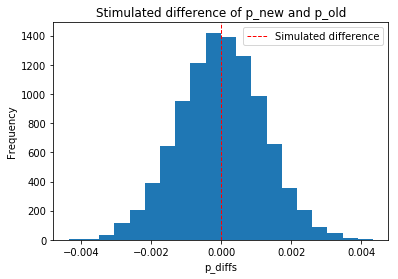

In [26]:
plt.hist(p_diffs, bins=20)
plt.xlabel("p_diffs")
plt.ylabel("Frequency")
plt.title("Stimulated difference of p_new and p_old")
plt.axvline(x=(np.array(p_diffs).mean()), color='r', linestyle='dashed', linewidth=1, label="Simulated difference")
plt.legend()
plt.show()

> The stimulated difference of $p_{new}$ and $p_{old}$ data shows normal distribution as expected.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
actual_diff = df.query("group == 'treatment'").converted.mean() - df.query("group == 'control'").converted.mean()
p_diffs = np.array(p_diffs)
(actual_diff < p_diffs).mean()

0.88780000000000003

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

1. We have computed p-values.
2. In scientific studies, p-values is the probability for a given statistical model that, when the null hypothesis is true. The sample mean difference between two compared groups would be greater than or equal to the actual observed results.
3. We conclude that null hypothesis is true as old and new pages perform almost similarly.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = np.sum(df2.query("landing_page == 'old_page'").converted)
convert_new = np.sum(df2.query("landing_page == 'new_page'").converted)
n_old = len(df2.query("landing_page == 'old_page'"))
n_new = len(df2.query("landing_page == 'new_page'"))
print("convert_old: ", convert_old, " convert_new: ", convert_new, " n_old: ", n_old, " n_new: ", n_new)  

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


convert_old:  17489  convert_new:  17264  n_old:  145274  n_new:  145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
print("z-score:", z_score, " p-value: ", p_value)

z-score: -1.31092419842  p-value:  0.189883374482


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

1. z-score are measures of standard deviation, and helps us to decide whether to accept or reject the null hypothesis.
2. The p-value is approximately 0.189, so we conclude that the null hypothesis is correct.
3. Yes, we agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### _Logistic regression_

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# Make a copy of previous df and add dummy columns
df_test = df2.copy()
df_test['intercept'] = 1
df_test[['ab_page1', 'ab_page']] = pd.get_dummies(df_test['group'])
df_test.drop(['ab_page1'], axis=1, inplace=True)
df_test.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
logit = sm.Logit(df_test['converted'], df_test[['intercept', 'ab_page']])
predict = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
predict.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        21:33:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

1. p-value associated with ab_page is 0.190
2. In part II we have used z-test and here regression
3. Null and Alternative hypotheses associated with our regression model:

    $H_{0}$: $p_{new}$ - $p_{old}$ $=$ 0
    
    $H_{1}$: $p_{new}$ - $p_{old}$ $\neq$ 0
    

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Consider other factors to add into your regression model,  beacuse: 

1. Here we have used one factor to decide whether a user would convert or not.
2. So adding new factors into regression model is a good idea.
3. One factor could be the time spent on the webpage by user to decide the convert.
4. Another feature could be the number of times user visits the page and time of year the test id conducted. 

Disadvantages to adding additional terms into regression model:
- Features which have high impact on outcome should be included into regression model not every feature or factor accounts the same impact.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [33]:
# load & read countries data 
df_country = pd.read_csv("countries.csv")
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [34]:
# check for regions/countries
df_country['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [35]:
# create dummy columns
df_dummy = df_country.copy()
df_dummy[['CA', 'UK', 'US']] = pd.get_dummies(df_dummy['country'])
df_dummy.tail()

,user_id,country,CA,UK,US
290579,653118,US,0,0,1
290580,878226,UK,0,1,0
290581,799368,UK,0,1,0
290582,655535,CA,1,0,0
290583,934996,UK,0,1,0


In [36]:
# create a duplicate copy of previous df and join the df with country data
df_ref = df_test.copy()
df_master = df_ref.set_index('user_id').join(df_dummy.set_index('user_id'), how='inner')
df_master.drop(['country'], axis=1, inplace=True)
df_master.tail()

,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,
751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,0,0,1
945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,0,0,1
734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,0,0,1
697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,0,0,1
715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1,0,1,0


In [37]:
# check the datatype for new columns
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 851104 to 715931
Data columns (total 9 columns):
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
CA              290584 non-null uint8
UK              290584 non-null uint8
US              290584 non-null uint8
dtypes: int64(2), object(3), uint8(4)
memory usage: 14.4+ MB


In [38]:
# convert it to int64
df_master[['ab_page', 'CA', 'UK', 'US']] = df_master[['ab_page', 'CA', 'UK', 'US']].astype(int)
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 851104 to 715931
Data columns (total 9 columns):
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null int64
CA              290584 non-null int64
UK              290584 non-null int64
US              290584 non-null int64
dtypes: int64(6), object(3)
memory usage: 22.2+ MB


In [39]:
# apply regression
logit_1 = sm.Logit(df_master['converted'], df_master[['intercept', 'UK', 'US']])
predict_1 = logit_1.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [40]:
# check the summary
predict_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 23 Dec 2018   Pseudo R-squ.:               1.521e-05
Time:                        21:37:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

- It appear that country had a little impact on conversion.
- Statistical output:
    - p-value for US is 0.129 and 
    - p-value for UK is 0.074
  

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
# apply regression
logit_2 = sm.Logit(df_master['converted'], df_master[['intercept', 'ab_page', 'UK', 'US']])
predict_2 = logit_2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [42]:
# see summary for interaction between page and country
predict_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 23 Dec 2018   Pseudo R-squ.:               2.323e-05
Time:                        21:38:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

- Statistical results:
    - p-values has increased for example ab_page is now 0.191, $\&$ US is 0.130
    - z for intercept is now -76.249

### Results:

1. After analyzing the dataset for e-commerce website it seems that our _Null hypothesis_ is correct. 
2. From probability we can conclude that: 
    - Conversion for control group is higher.
    - The control group does better but with a small margin.
3. From histogram we can see that null hypothesis is true as old and new pages perform almost similarly.
4. We have also seen that country alone has little impact on the conversion.
5. The test conditions were fairly good as well, because user had a equal chance to receive old and new pages.
6. An interaction between page and country has significant effects on conversion.

## Conclusion: 

I recommend the e-commerce website company to keep the "old pages" for now $\&$ spend time to improve the new pages before they go for another experiment and then finalize the decision.

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0